## TOML file format for parameter files

Demonstrates using TOML as file format for registration parameters and transformation parameters.


Let's start by importing packages and defining a few helper functions.

In [1]:
import itk

# import tomllib without installing external package, as suggested by Tommy Wolfheart, Jan 23, 2025,
# https://stackoverflow.com/questions/75115582/how-to-load-toml-file-in-python/79380110#79380110
try:
    import tomllib  # Python v3.11+
except ModuleNotFoundError:
    import pip._vendor.tomli as tomllib  # the same tomllib that's now included in Python v3.11+

import math
import matplotlib.pyplot as plt
import os
import pathlib
import pprint


# Shows the specified image onto the specified axis.
def show_image(ax, image, title: str):
    ax.set_title(title)
    ax.imshow(cmap="binary_r", origin="lower", X=itk.array_view_from_image(image))


# Print the contents of the specified file.
def print_file_contents(file_name: str):
    with open(file_name, "r") as input_file:
        print(file_name + " file contents:\n", input_file.read(), sep="\n")


# Loads the Python dict from the specified TOML file, and prints it.
def print_toml_dict(file_name: str):
    print(file_name + " as Python dict:\n")
    with open(file_name, "rb") as input_file:
        toml_document = tomllib.load(input_file)
        pprint.pprint(toml_document)
    print()

Create the Input and Output directories for the registration, and write two TOML parameter files to the Input directory: a registration parameter file and a transformation parameter file (for the initial transformation).

Note that the registration parameter file has parameter `OutputTransformParameterFileFormat = "TOML"`, specifying that the output transform parameter files should also have the TOML file format.

In [2]:
example_subdirectory_name = "Example_TomlFileFormatForParameterFiles"

# Create an example subdirectory, if it isn't there already.
if os.path.basename(os.getcwd()) != example_subdirectory_name:
    pathlib.Path(example_subdirectory_name).mkdir(exist_ok=True)
    os.chdir(example_subdirectory_name)
current_directory_path = os.getcwd()

# Create an input and an output directory.
pathlib.Path("Input").mkdir(exist_ok=True)
# Create an output directory.
pathlib.Path("Output").mkdir(exist_ok=True)

# Create parameter files in the TOML file format.
with open("Input/registration_parameter_file.toml", "w") as output_file:
    print(
        "# Registration parameters",
        'ImageSampler = "Full"',
        "MaximumNumberOfIterations = 2",
        'Metric = "AdvancedNormalizedCorrelation"',
        'Optimizer = "AdaptiveStochasticGradientDescent"',
        'OutputTransformParameterFileFormat = "TOML"',
        'Transform = "TranslationTransform"',
        sep="\n",
        file=output_file,
    )
with open("Input/initial_transform_parameters.toml", "w") as output_file:
    print(
        "# Initial transformation",
        "CenterOfRotationPoint = [ 0.0, 0.0 ]",
        "NumberOfParameters = 3",
        'Transform = "EulerTransform"',
        f"TransformParameters = [ {math.pi/2.0}, 0.0, 0.0 ]",
        sep="\n",
        file=output_file,
    )

Show the contents of the parameter files we just created.

In [3]:
print("Current directory:", os.getcwd(), "\n")
print_file_contents("Input/initial_transform_parameters.toml")
print_toml_dict("Input/initial_transform_parameters.toml")
print_file_contents("Input/registration_parameter_file.toml")
print_toml_dict("Input/registration_parameter_file.toml")

Current directory: C:\Users\cedekker\__My_Jupyter_Notebooks\D-X-Src-I-ITKElastix-examples\Example_TomlFileFormatForParameterFiles 

Input/initial_transform_parameters.toml file contents:

# Initial transformation
CenterOfRotationPoint = [ 0.0, 0.0 ]
NumberOfParameters = 3
Transform = "EulerTransform"
TransformParameters = [ 1.5707963267948966, 0.0, 0.0 ]

Input/initial_transform_parameters.toml as Python dict:

{'CenterOfRotationPoint': [0.0, 0.0],
 'NumberOfParameters': 3,
 'Transform': 'EulerTransform',
 'TransformParameters': [1.5707963267948966, 0.0, 0.0]}

Input/registration_parameter_file.toml file contents:

# Registration parameters
ImageSampler = "Full"
MaximumNumberOfIterations = 2
Metric = "AdvancedNormalizedCorrelation"
Optimizer = "AdaptiveStochasticGradientDescent"
OutputTransformParameterFileFormat = "TOML"
Transform = "TranslationTransform"

Input/registration_parameter_file.toml as Python dict:

{'ImageSampler': 'Full',
 'MaximumNumberOfIterations': 2,
 'Metric': 'Adva

Read the registration parameters from the TOML file into a `ParameterObject`.

In [4]:
registration_parameter_object = itk.ParameterObject.New()
registration_parameter_object.ReadParameterFile(
    "Input/registration_parameter_file.toml"
)
print(registration_parameter_object)

ParameterObject (0000018D3C509AD0)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 66
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (ImageSampler "Full")
  (MaximumNumberOfIterations 2)
  (Metric "AdvancedNormalizedCorrelation")
  (Optimizer "AdaptiveStochasticGradientDescent")
  (OutputTransformParameterFileFormat "TOML")
  (Transform "TranslationTransform")



Create two images, to be used as _fixed_ and _moving_ image.

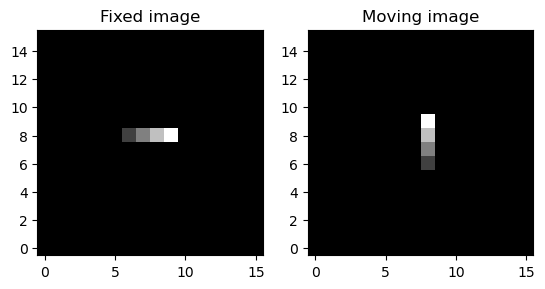

In [5]:
image_size = [16, 16]


def create_image(image_size):
    PixelType = itk.SS
    ImageType = itk.Image[PixelType, len(image_size)]
    # Place the origin in the center of the image, as it is used as center of rotation.
    image = ImageType.New(
        regions=image_size, origin=(-image_size[0] / 2.0, -image_size[1] / 2.0)
    )
    image.AllocateInitialized()
    return image


fixed_image = create_image(image_size)
moving_image = create_image(image_size)

for i in range(4):
    pixel_value = i + 1
    for j in range(8, 9):
        fixed_image.SetPixel((i + 6, j), pixel_value)
    for j in range(8, 9):
        moving_image.SetPixel((j, i + 6), pixel_value)

fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
show_image(ax1, fixed_image, "Fixed image")
show_image(ax2, moving_image, "Moving image")
plt.show()

Now run the registration, registering the two images, using the initial transform specified by the TOML file, and the registration parameters from the parameter object.

In [6]:
result_image, result_transform_parameter_object = itk.elastix_registration_method(
    fixed_image=fixed_image,
    moving_image=moving_image,
    initial_transform_parameter_file_name="Input/initial_transform_parameters.toml",
    parameter_object=registration_parameter_object,
    output_directory="Output",
)

Look at the result. The result image is very much like the fixed image, so the registration was successful! The resulting transformation can be inspected by looking at the returned transform parameter object, but also by looking at the "TransformParameters.0.toml" file that was placed in the output directory.

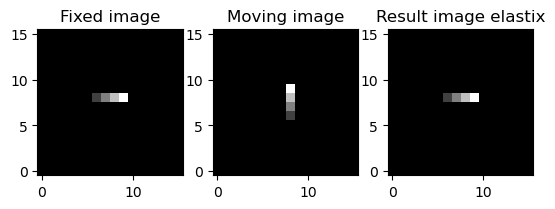

ParameterObject (0000018D49E67390)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2239
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CompressResultImage "false")
  (DefaultPixelValue)
  (Direction 1 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 2)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0)
  (InitialTransformParameterFileName "Input/initial_transform_parameters.toml")
  (MovingImageDimension 2)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 2)
  (Origin -8 -8)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "mhd")
  (ResultImagePixelType "short")
  (Size 16 16)
  (Spacing 1 1)
  (Transform "TranslationTransform")
  (TransformParameters 5.44787e-09 2.55696e-08)
  (UseDirectionCosines "true")

Output/TransformParameters.0.toml file contents:

Direction = [1, 0, 0, 1]
FixedImageDime

In [7]:
fig = plt.figure()
ax1, ax2, ax3 = fig.subplots(1, 3)
show_image(ax1, fixed_image, "Fixed image")
show_image(ax2, moving_image, "Moving image")
show_image(ax3, result_image, "Result image elastix")
plt.show()

print(result_transform_parameter_object)
print_file_contents("Output/TransformParameters.0.toml")
print_toml_dict("Output/TransformParameters.0.toml")

The TOML file generated by the registration can be passed directly to transformix, to apply the found transformation onto the moving image: 

In [8]:
result_image_transformix = itk.transformix_filter(
    moving_image, transform_parameter_file_name="Output/TransformParameters.0.toml"
)

And here is the transformix result:

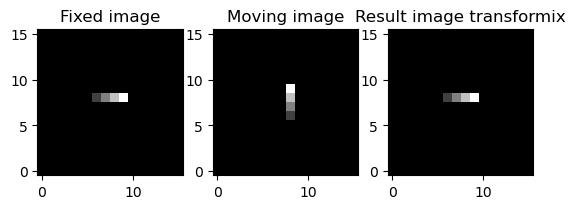

In [9]:
fig = plt.figure()
ax1, ax2, ax3 = fig.subplots(1, 3)
show_image(ax1, fixed_image, "Fixed image")
show_image(ax2, moving_image, "Moving image")
show_image(ax3, result_image_transformix, "Result image transformix")
plt.show()

Summary, as shown by this notebook: elastix supports TOML files as input for registration parameters (via a `ParameterObject`) and (initial) transform parameters. It can also produce TOML files as output, when you specify the registration parameter `OutputTransformParameterFileFormat = "TOML"`. transformix supports TOML files as input for transform parameters.

## Bonus: Direct passage of a dict of TOML values

A TOML dict (e.g. produced by `tomllib`) can be passed directly to `itk.dict_to_parameter_object`,
which converts Python-native types (str, bool, int, float, and lists thereof) to the elastix
ParameterMap format automatically. The dict can also be passed directly to
`itk.elastix_registration_method` and `itk.transformix_filter` as the `parameter_object`
or `transform_parameter_object` argument.

In [10]:
toml_dict = tomllib.loads(
    """
# Example transformation
NumberOfParameters = 2
Transform = "TranslationTransform"
TransformParameters = [ 1.2345, -1048 ]
"""
)

print(toml_dict)

# Direct passage: the dict is automatically converted to a ParameterObject
parameter_object = itk.dict_to_parameter_object(toml_dict)

print(parameter_object)